## Exploratory Data Analysis 

In [1]:
# 1. IMPORTS AND DATA LOADING
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pathlib import Path

In [3]:
# Load your cleaned data
df = pd.read_parquet("../data/processed/traffic_weather_clean.parquet")
graph_data = torch.load("../data/processed/graph_structure.pt")

print("Data loaded successfully!")
print(f"Data shape: {df.shape}")
print(f"Time range: {df.index.min()} to {df.index.max()}")

Data loaded successfully!
Data shape: (184872, 21)
Time range: 2025-04-01 00:00:00+00:00 to 2025-10-31 23:00:00+00:00


/tmp/ipykernel_4340/3170825822.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_data = torch.load("../data/processed/graph_structure.pt")


### Traffic Data Distribution

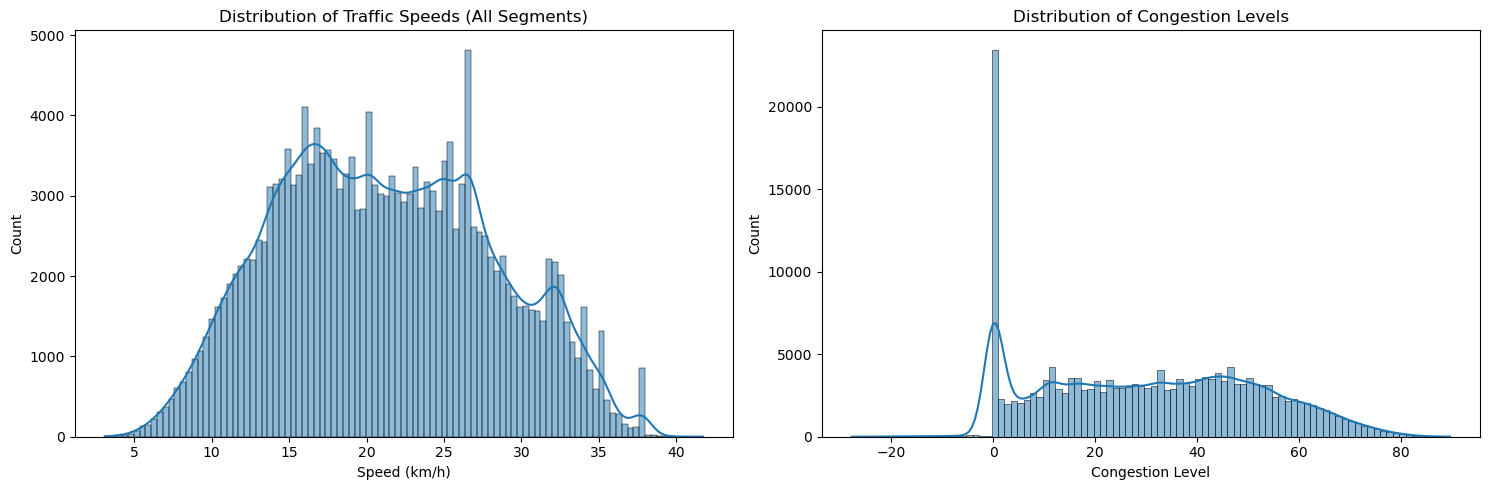

In [4]:
# 1.1 Overall distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Traffic speed distribution
sns.histplot(df['traffic_speed'], kde=True, ax=axes[0])
axes[0].set_title("Distribution of Traffic Speeds (All Segments)")
axes[0].set_xlabel("Speed (km/h)")

# Congestion level distribution  
sns.histplot(df['congestion_level'], kde=True, ax=axes[1])
axes[1].set_title("Distribution of Congestion Levels")
axes[1].set_xlabel("Congestion Level")

plt.tight_layout()
plt.show()

### Traffic Patterns by Road Segment

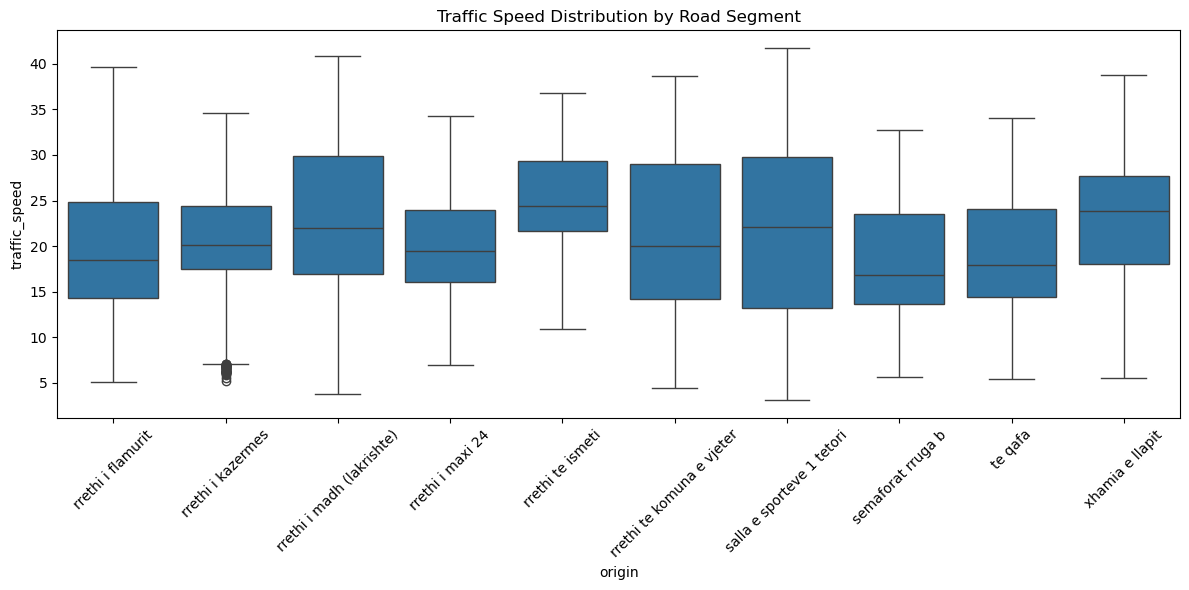

In [6]:
# Boxplot by segment
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='origin', y='traffic_speed')
plt.title("Traffic Speed Distribution by Road Segment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

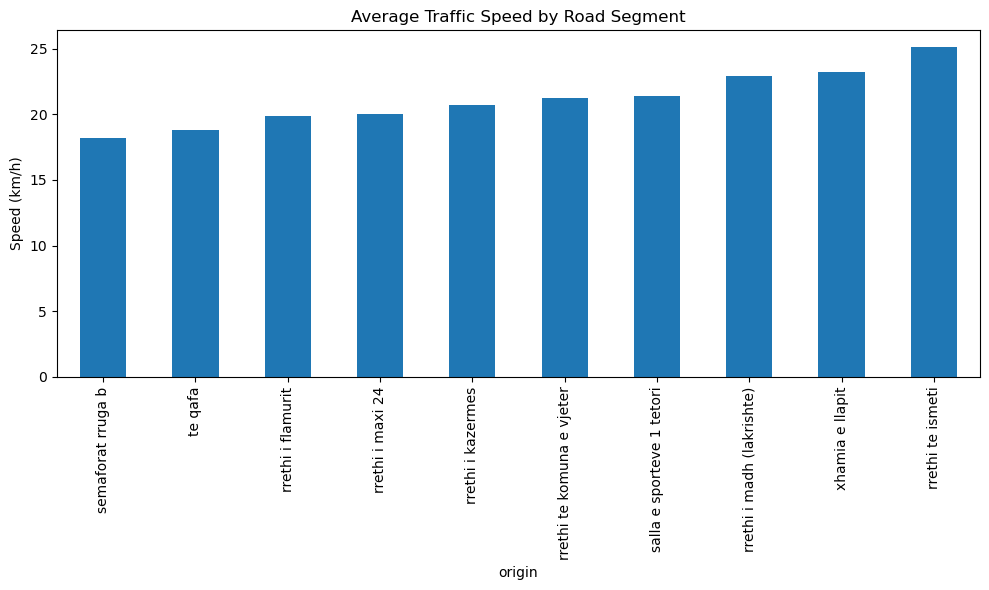

In [7]:
# Average speed per segment
segment_speeds = df.groupby('origin', observed=True)['traffic_speed'].mean().sort_values()
plt.figure(figsize=(10, 6))
segment_speeds.plot(kind='bar')
plt.title("Average Traffic Speed by Road Segment")
plt.ylabel("Speed (km/h)")
plt.tight_layout()
plt.show()

### Temporal Patterns

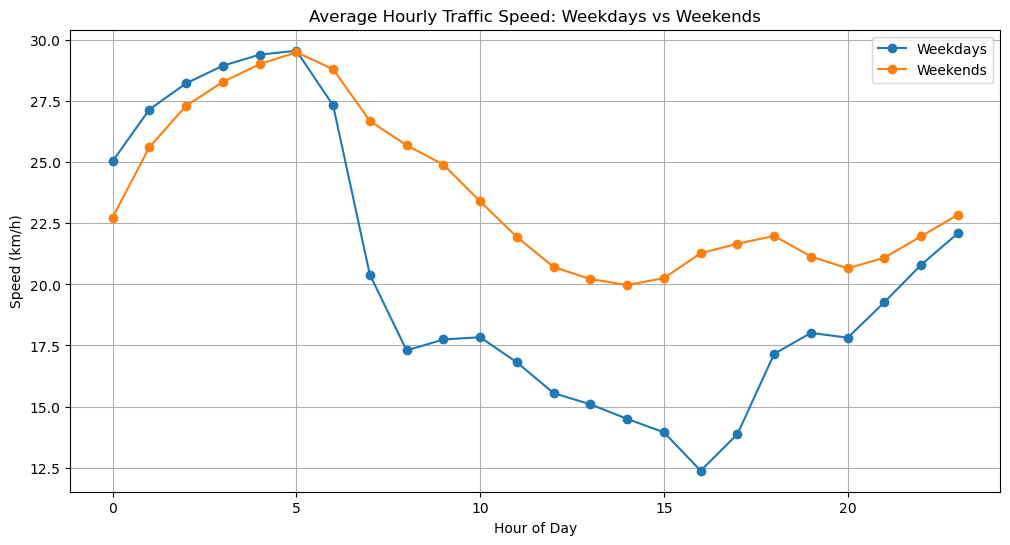

In [8]:
# Daily patterns (weekdays vs weekends)
weekday_hourly = df[df['is_weekend'] == 0].groupby('hour')['traffic_speed'].mean()
weekend_hourly = df[df['is_weekend'] == 1].groupby('hour')['traffic_speed'].mean()

plt.figure(figsize=(12, 6))
plt.plot(weekday_hourly.index, weekday_hourly.values, label='Weekdays', marker='o')
plt.plot(weekend_hourly.index, weekend_hourly.values, label='Weekends', marker='o')
plt.title("Average Hourly Traffic Speed: Weekdays vs Weekends")
plt.xlabel("Hour of Day")
plt.ylabel("Speed (km/h)")
plt.legend()
plt.grid(True)
plt.show()

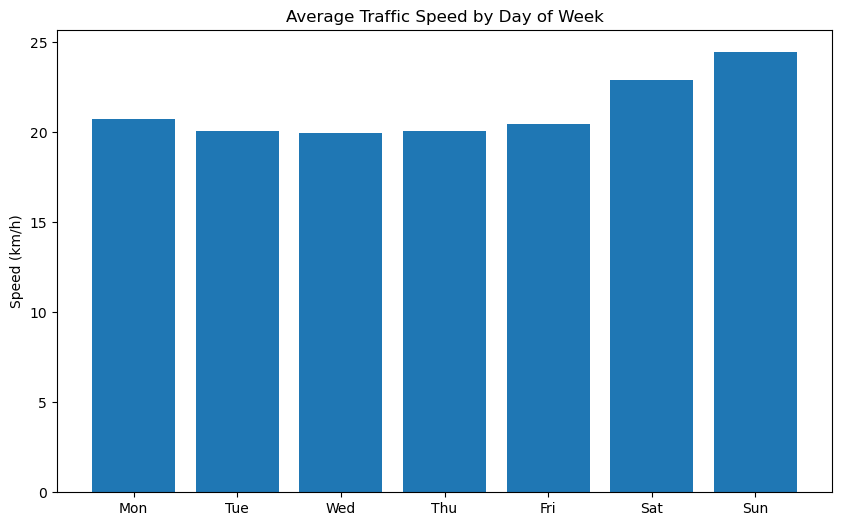

In [9]:
# Weekly patterns
daily_speeds = df.groupby('dayofweek')['traffic_speed'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.figure(figsize=(10, 6))
plt.bar(days, daily_speeds)
plt.title("Average Traffic Speed by Day of Week")
plt.ylabel("Speed (km/h)")
plt.show()

### Weather Analysis

/tmp/ipykernel_4340/2359025934.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df[numeric_cols].resample('6H').mean()  # Only numeric columns


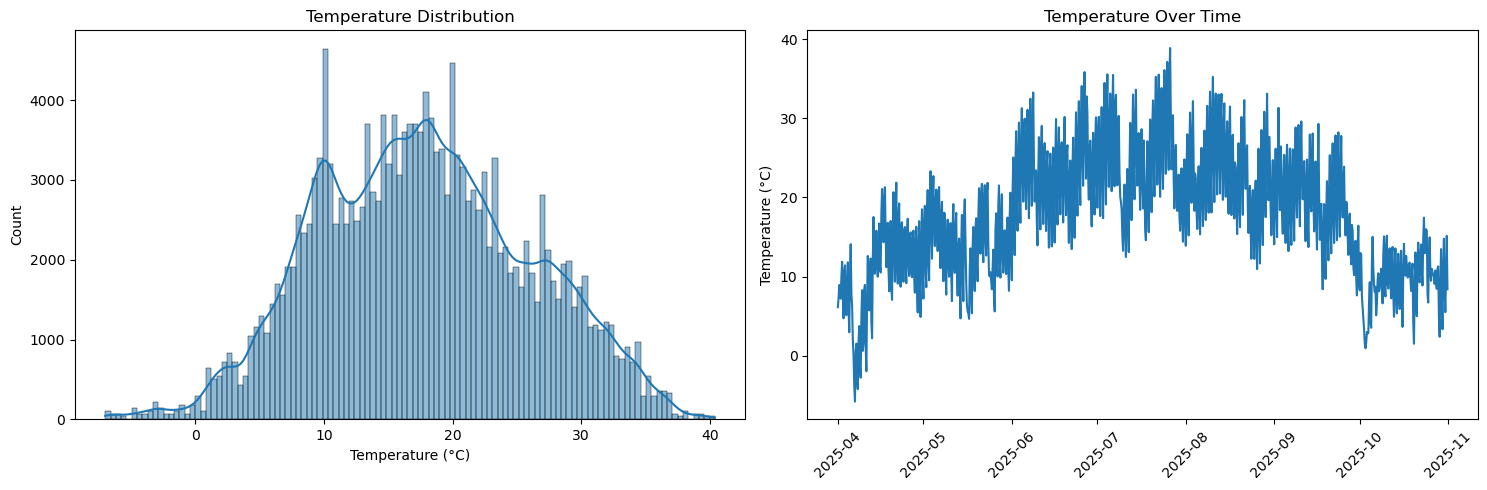

In [10]:
# Temperature patterns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Temperature distribution
sns.histplot(df['temperature'], kde=True, ax=axes[0])
axes[0].set_title("Temperature Distribution")
axes[0].set_xlabel("Temperature (°C)")

# Temperature over time - select only numeric columns for resampling
numeric_cols = df.select_dtypes(include=[np.number]).columns
df_resampled = df[numeric_cols].resample('6H').mean()  # Only numeric columns

axes[1].plot(df_resampled.index, df_resampled['temperature'])
axes[1].set_title("Temperature Over Time")
axes[1].set_ylabel("Temperature (°C)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [11]:
# 4.2 Precipitation analysis
print("Precipitation Statistics:")
print(f"Dry periods: {(df['precipitation'] == 0).sum()} records")
print(f"Rainy periods: {(df['precipitation'] > 0).sum()} records")
print(f"Max precipitation: {df['precipitation'].max()} mm")

Precipitation Statistics:
Dry periods: 168024 records
Rainy periods: 16848 records
Max precipitation: 7.3 mm


### Traffic vs Weather Relationships

In [12]:
# Speed vs Precipitation
rainy_speed = df[df['precipitation'] > 0]['traffic_speed'].mean()
dry_speed = df[df['precipitation'] == 0]['traffic_speed'].mean()

print(f"Average speed on rainy intervals: {rainy_speed:.2f} km/h")
print(f"Average speed on dry intervals: {dry_speed:.2f} km/h")
print(f"Difference: {dry_speed - rainy_speed:.2f} km/h")

Average speed on rainy intervals: 19.85 km/h
Average speed on dry intervals: 21.35 km/h
Difference: 1.50 km/h


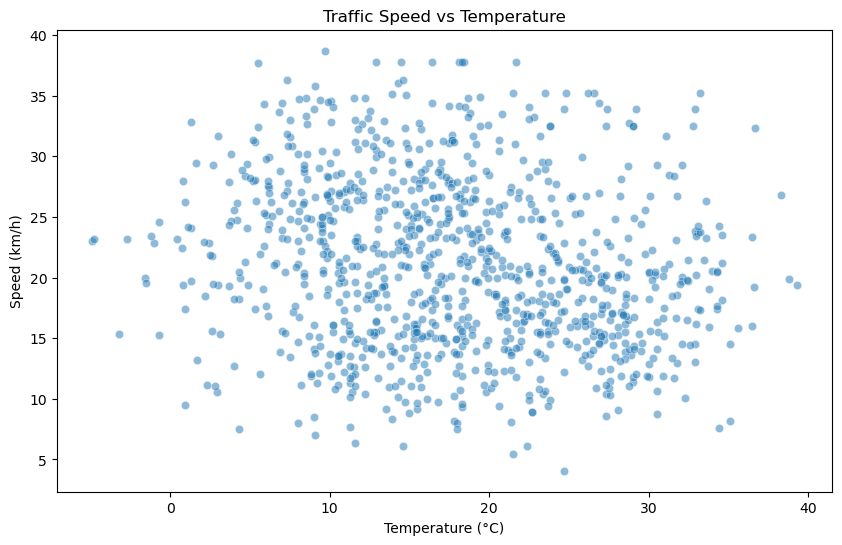

In [13]:
# Scatter plot: Speed vs Temperature
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df.sample(1000), x='temperature', y='traffic_speed', alpha=0.5)
plt.title("Traffic Speed vs Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Speed (km/h)")
plt.show()

### Spatial Analysis with Graph Structure

/tmp/ipykernel_4340/1011160004.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  speed_pivot = df.pivot_table(values='traffic_speed',


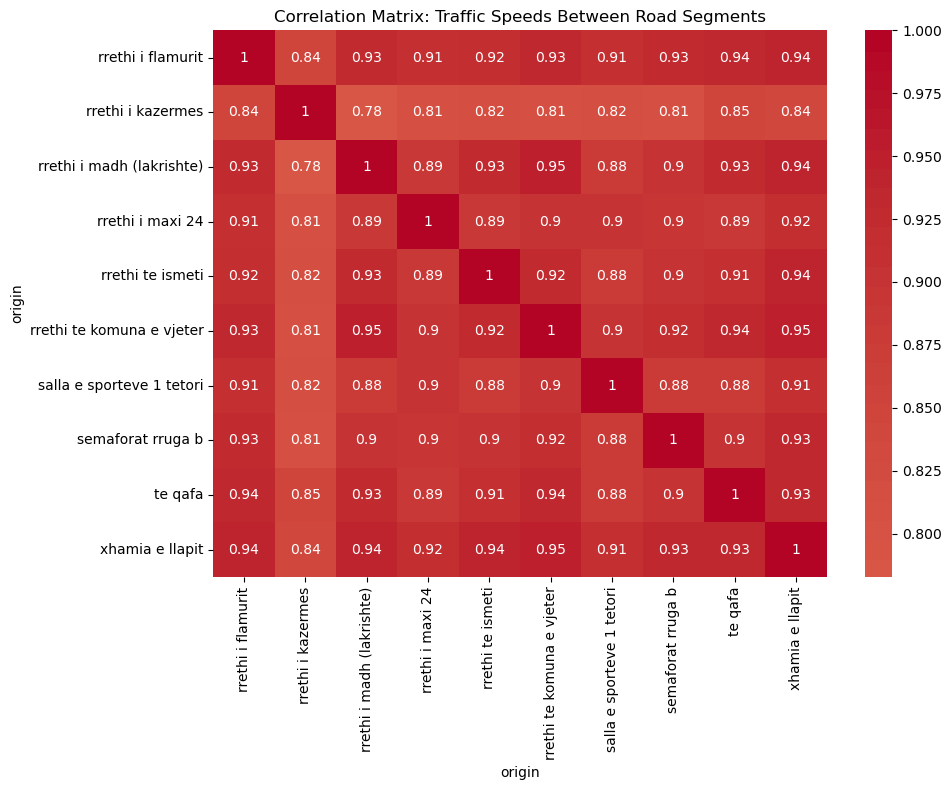

In [14]:
# Correlation matrix between segments
# Pivot to get segment speeds as columns
speed_pivot = df.pivot_table(values='traffic_speed', 
                            index=df.index, 
                            columns='origin', 
                            aggfunc='mean')

# Compute correlation matrix
corr_matrix = speed_pivot.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix: Traffic Speeds Between Road Segments")
plt.tight_layout()
plt.show()

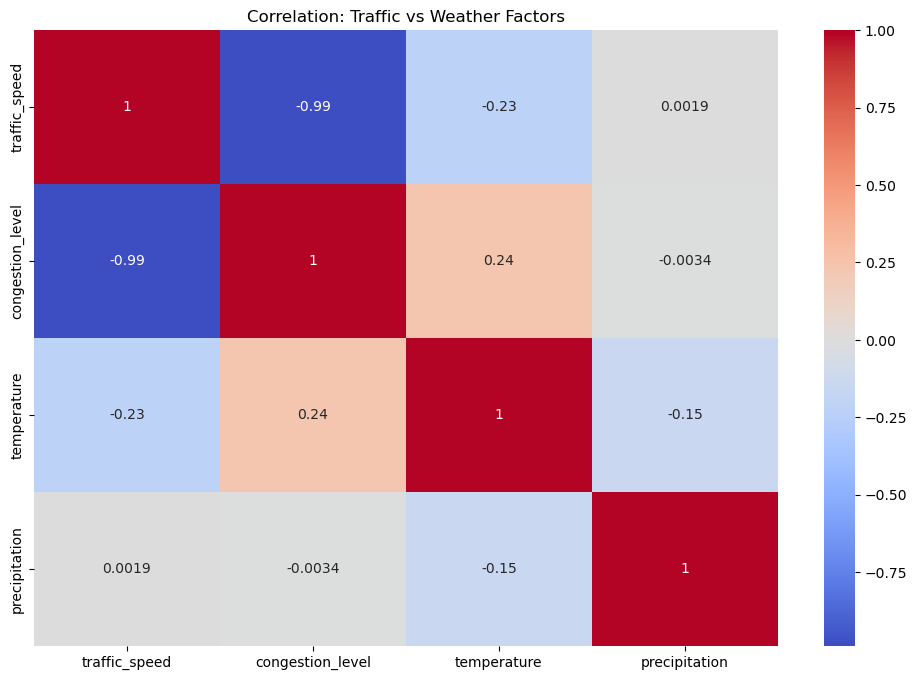

In [15]:
# Analyze how weather impacts traffic
weather_cols = [col for col in df.columns if 'weather' in col.lower() or 'temp' in col.lower() or 'precip' in col.lower()]

# Correlation matrix
corr_matrix = df[['traffic_speed', 'congestion_level'] + weather_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation: Traffic vs Weather Factors')
plt.show()